In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
!pip install emoji
import emoji

!pip list
!pip install seaborn
!pip install scikit-learn
!pip install optuna
!pip install spacy
!pip install langdetect


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Package                   Version
------------------------- --------------
alembic                   1.15.2
annotated-types           0.7.0
anyascii                  0.3.2
anyio                     4.9.0
appnope                   0.1.4
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.5
attrs                     25.3.0
babel                     2.17.0
beautifulsoup4            4.13.4
bleach                    6.2.0
blis                      1.3.0
catalogue                 2.0.10
certifi                   2025.1.31
cffi                      1.17.1
charset-normalizer        3.4.1
click                     8.1.8
cloudpathlib              0.21.0
colorlog                  6.9.0
comm                      0.2.2
confection                0.1.5
contourpy                 1.3.2
c

In [3]:
df=pd.read_csv('scitweets_balanced.tsv', sep='\t')
display (df.head())

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0.0,3.166700e+17,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1.0,3.190909e+17,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2.0,3.220309e+17,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3.0,3.226948e+17,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4.0,3.285244e+17,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


In [4]:
import re
import emoji

def convert_emojis(text):
    return emoji.demojize(text)  # Convertit 😊 en :smiling_face_with_smiling_eyes:

df['text'] = df['text'].apply(convert_emojis)

# Détection d’URL "normaux"
df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)

# Détection de mentions (@username)
df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)

# Détection de hashtags (#mot)
df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)

# détection emojis
df['has_emoji'] = df['text'].str.contains(r':[^:\s]+:')

# Fonction d’agrégation
def count_by_category(col):
    return df.groupby('science_related')[col].sum()

print("- Tweets avec URL :")
display(count_by_category('has_url'))

print("- Tweets avec Mention :")
display(count_by_category('has_mention'))

print("- Tweets avec Hashtag :")
display(count_by_category('has_hashtag'))

print("- Tweets avec Emoji :")
display(df.groupby('science_related')['has_emoji'].sum())



- Tweets avec URL :


science_related
0    429
1    602
Name: has_url, dtype: int64

- Tweets avec Mention :


science_related
0    285
1    195
Name: has_mention, dtype: int64

- Tweets avec Hashtag :


science_related
0    249
1    349
Name: has_hashtag, dtype: int64

- Tweets avec Emoji :


science_related
0    81
1    13
Name: has_emoji, dtype: int64

In [5]:
def clean_text_for_model(text):
    text = text.lower()
    text = re.sub(r"http\S+", "URL", text)
    text = re.sub(r"@\w+", "MENTION", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^\w\s:]", "", text)
    return text

df['text_clean'] = df['text'].apply(clean_text_for_model)
print(df['text_clean'])

import re
import spacy
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# 🔹 Charger les modèles spaCy pour FR et EN
nlp_fr = spacy.load("fr_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

# 🔹 Fonction de nettoyage + lemmatisation multilingue
def clean_and_lemmatize_multilang(text):
    text = text.lower()
    text = re.sub(r"http\S+", "URL", text)
    text = re.sub(r"@\w+", "MENTION", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^\w\s:]", "", text)

    try:
        lang = detect(text)
    except:
        lang = "en"  # fallback

    if lang == "fr":
        doc = nlp_fr(text)
    else:
        doc = nlp_en(text)

    lemmatized = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return lemmatized


0       knees are a bit sore i guess thats a sign that...
1       mcdonalds breakfast stop then the gym :basketb...
2       can any gynecologist with cancer experience ex...
3       couchlock highs lead to sleeping in the couch ...
4       does daily routine help prevent problems with ...
                              ...                        
1525      i dont like URL much this is being promoted how
1526    this technology will stop snoring forever URL ...
1527    priority for future research on impact of covi...
1528    reading facebook comments for 20 minutes is sc...
1529    volume caps pills male sex enhancement increas...
Name: text_clean, Length: 1530, dtype: object


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 🔹 Nettoyage des valeurs manquantes
df.dropna(subset=['text'], inplace=True)

# 🔹 Application du nettoyage + lemmatisation
print("⏳ Nettoyage et lemmatisation en cours...")
df['text_clean'] = df['text'].apply(clean_and_lemmatize_multilang)
print("✅ Texte nettoyé et lemmatisé.")

# 🔹 Texte et labels
X_text = df['text_clean']
y = df['science_related']

# 🔹 TF-IDF vectorisation
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)

# 🔹 Ajouter les colonnes binaires
extra_features = df[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
X_extra = scipy.sparse.csr_matrix(extra_features.values)

# 🔹 Fusion TF-IDF + features binaires
X_final = scipy.sparse.hstack([X_tfidf, X_extra])

# 🔹 Affichage
print("📐 Taille de la matrice TF-IDF :", X_tfidf.shape)
print("📐 Taille finale avec features binaires :", X_final.shape)




⏳ Nettoyage et lemmatisation en cours...
✅ Texte nettoyé et lemmatisé.
📐 Taille de la matrice TF-IDF : (1530, 5523)
📐 Taille finale avec features binaires : (1530, 5527)


In [19]:
#------------------------------------------------------------------
#-------pre-traitement commplet------------------------
#----------------------------------------------------

In [9]:
stopwords_df = pd.read_csv("StopWordsFrench.csv", sep=',', index_col=0)
french_stopwords = stopwords_df.index.tolist()


# 🔹 Application lemmatisation multilangue
print("⏳ Nettoyage + lemmatisation (version 2)...")
df['text_clean_2'] = df['text'].apply(clean_and_lemmatize_multilang)
print("✅ Fini.")

# 🔹 TF-IDF avancé (version 2)
vectorizer2 = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    stop_words=french_stopwords,
    lowercase=False,
    ngram_range=(1, 2),
    max_features=50000
)
X_tfidf2 = vectorizer2.fit_transform(df['text_clean_2'])

# ➕ DataFrame version 2
tfidf_df2 = pd.DataFrame(X_tfidf2.toarray(), columns=vectorizer2.get_feature_names_out())

# 🔹 Filtrage des tokens
def is_valid_token(token):
    if token.isdigit():
        return False
    return bool(re.match(r'^[a-zA-Z]+$', token))

valid_columns2 = [token for token in tfidf_df2.columns if is_valid_token(token)]
numeric_columns2 = [token for token in tfidf_df2.columns if token.isdigit()]

tfidf_df2['numeric'] = tfidf_df2[numeric_columns2].sum(axis=1) if numeric_columns2 else 0
tfidf_df2.drop(columns=numeric_columns2, inplace=True)

tfidf_filtered_df2 = tfidf_df2[valid_columns2 + ['numeric']]

# 🔹 Features binaires
extra_features2 = df[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
X_extra2 = scipy.sparse.csr_matrix(extra_features2.values)

# 🔹 Fusion finale version 2
X_final2 = scipy.sparse.hstack([scipy.sparse.csr_matrix(tfidf_filtered_df2.values), X_extra2])
y2 = df['science_related']

# 🔹 Affichage
print("📐 Taille TF-IDF filtrée (v2) :", tfidf_filtered_df2.shape)
print("📐 Taille finale avec features binaires (v2) :", X_final2.shape)

⏳ Nettoyage + lemmatisation (version 2)...
✅ Fini.
📐 Taille TF-IDF filtrée (v2) : (1530, 740)
📐 Taille finale avec features binaires (v2) : (1530, 744)


In [10]:
# (80% entraînement, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_final2, y, test_size=0.2, random_state=42, stratify=df['science_related'])
#print(X_test)

print(f"Taille du jeu d'entraînement : {X_train.shape[0]} échantillons")
print(f"Taille du jeu de test : {X_test.shape[0]} échantillons")

Taille du jeu d'entraînement : 1224 échantillons
Taille du jeu de test : 306 échantillons



🔍 Entraînement du modèle : Naïve Bayes

📊 Scores Test : Naïve Bayes
Accuracy : 0.88 | Precision : 0.88 | Recall : 0.88 | F1 : 0.88
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       153
           1       0.88      0.88      0.88       153

    accuracy                           0.88       306
   macro avg       0.88      0.88      0.88       306
weighted avg       0.88      0.88      0.88       306

🧩 Matrice de confusion :
[[134  19]
 [ 19 134]]


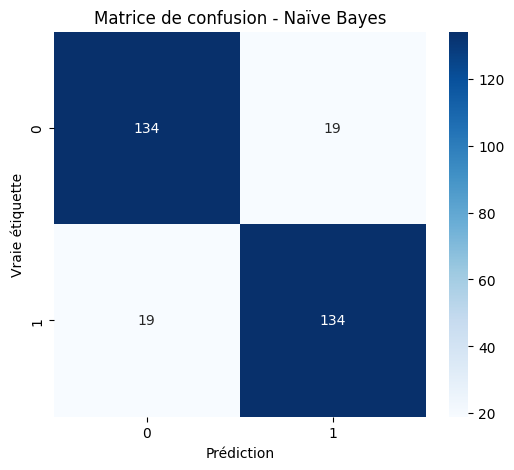

--------------------------------------------------

🔍 Entraînement du modèle : Random Forest

📊 Scores Test : Random Forest
Accuracy : 0.90 | Precision : 0.90 | Recall : 0.90 | F1 : 0.90
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       153
           1       0.91      0.90      0.90       153

    accuracy                           0.90       306
   macro avg       0.90      0.90      0.90       306
weighted avg       0.90      0.90      0.90       306

🧩 Matrice de confusion :
[[139  14]
 [ 16 137]]


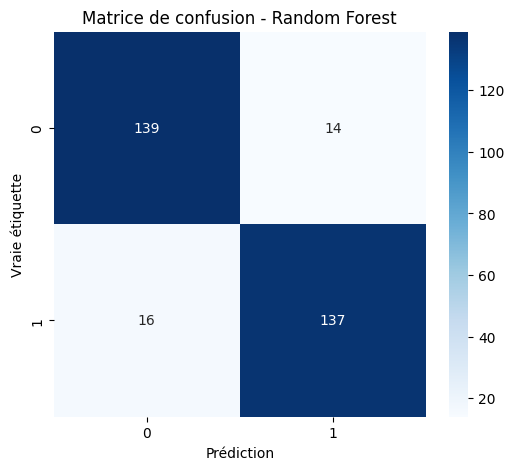

--------------------------------------------------

🔍 Entraînement du modèle : SVM sans params

📊 Scores Test : SVM sans params
Accuracy : 0.91 | Precision : 0.91 | Recall : 0.91 | F1 : 0.91
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       153
           1       0.91      0.91      0.91       153

    accuracy                           0.91       306
   macro avg       0.91      0.91      0.91       306
weighted avg       0.91      0.91      0.91       306

🧩 Matrice de confusion :
[[139  14]
 [ 14 139]]


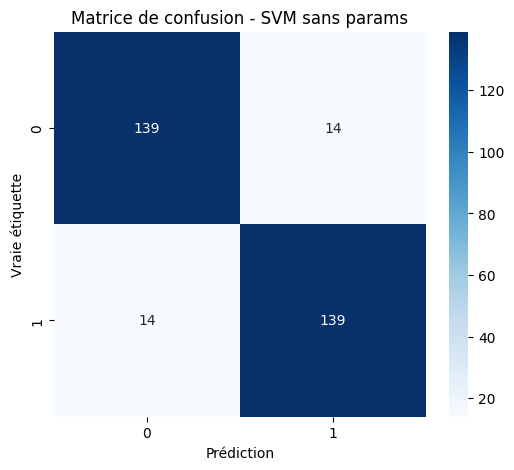

--------------------------------------------------

🔍 Entraînement du modèle : KNN sans params

📊 Scores Test : KNN sans params
Accuracy : 0.72 | Precision : 0.73 | Recall : 0.72 | F1 : 0.71
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.78      0.60      0.68       153
           1       0.68      0.83      0.74       153

    accuracy                           0.72       306
   macro avg       0.73      0.72      0.71       306
weighted avg       0.73      0.72      0.71       306

🧩 Matrice de confusion :
[[ 92  61]
 [ 26 127]]


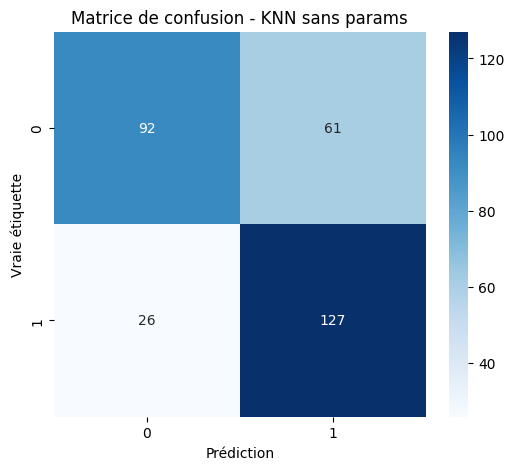

--------------------------------------------------

🔍 Entraînement du modèle : AdaBoost

📊 Scores Test : AdaBoost
Accuracy : 0.80 | Precision : 0.80 | Recall : 0.80 | F1 : 0.80
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       153
           1       0.81      0.78      0.80       153

    accuracy                           0.80       306
   macro avg       0.80      0.80      0.80       306
weighted avg       0.80      0.80      0.80       306

🧩 Matrice de confusion :
[[125  28]
 [ 33 120]]


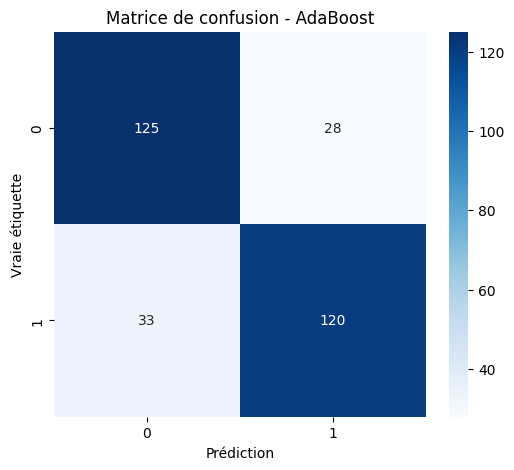

--------------------------------------------------

🔍 Entraînement du modèle : XGBoost sans params

📊 Scores Test : XGBoost sans params
Accuracy : 0.88 | Precision : 0.88 | Recall : 0.88 | F1 : 0.88
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       153
           1       0.89      0.88      0.88       153

    accuracy                           0.88       306
   macro avg       0.88      0.88      0.88       306
weighted avg       0.88      0.88      0.88       306

🧩 Matrice de confusion :
[[136  17]
 [ 19 134]]


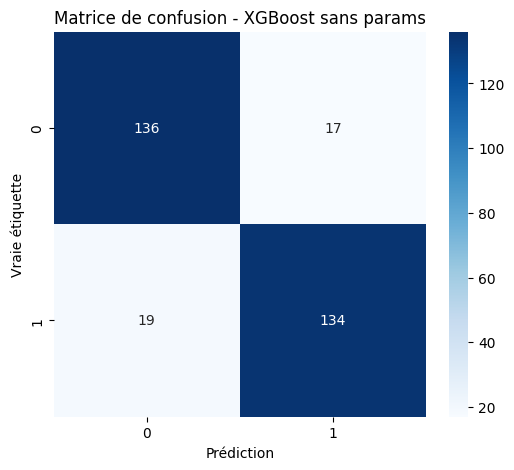

--------------------------------------------------

🔍 Entraînement du modèle : Neural Network - MLP

📊 Scores Test : Neural Network - MLP
Accuracy : 0.88 | Precision : 0.88 | Recall : 0.88 | F1 : 0.88
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       153
           1       0.89      0.87      0.88       153

    accuracy                           0.88       306
   macro avg       0.88      0.88      0.88       306
weighted avg       0.88      0.88      0.88       306

🧩 Matrice de confusion :
[[137  16]
 [ 20 133]]


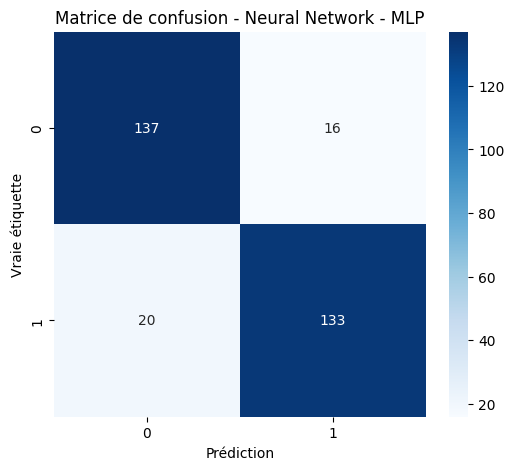

--------------------------------------------------


,Accuracy,Precision,Recall,F1 Score,CV Accuracy,CV Precision,CV Recall,CV F1 Score
Naïve Bayes,0.88,0.88,0.88,0.88,0.82 ± 0.02,0.84 ± 0.02,0.82 ± 0.02,0.81 ± 0.02
Random Forest,0.90,0.90,0.90,0.90,0.89 ± 0.02,0.90 ± 0.02,0.89 ± 0.02,0.88 ± 0.01
SVM sans params,0.91,0.91,0.91,0.91,0.90 ± 0.02,0.90 ± 0.02,0.90 ± 0.02,0.90 ± 0.02
KNN sans params,0.72,0.73,0.72,0.71,0.75 ± 0.02,0.77 ± 0.02,0.75 ± 0.02,0.74 ± 0.02
AdaBoost,0.80,0.80,0.80,0.80,0.75 ± 0.03,0.75 ± 0.02,0.75 ± 0.03,0.75 ± 0.03
XGBoost sans params,0.88,0.88,0.88,0.88,0.85 ± 0.01,0.85 ± 0.01,0.85 ± 0.01,0.85 ± 0.01
Neural Network - MLP,0.88,0.88,0.88,0.88,0.90 ± 0.03,0.90 ± 0.03,0.90 ± 0.03,0.90 ± 0.04


/var/folders/pf/x8z57h4121s6cmtp02twbdd00000gn/T/ipykernel_37156/1335867773.py:104: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


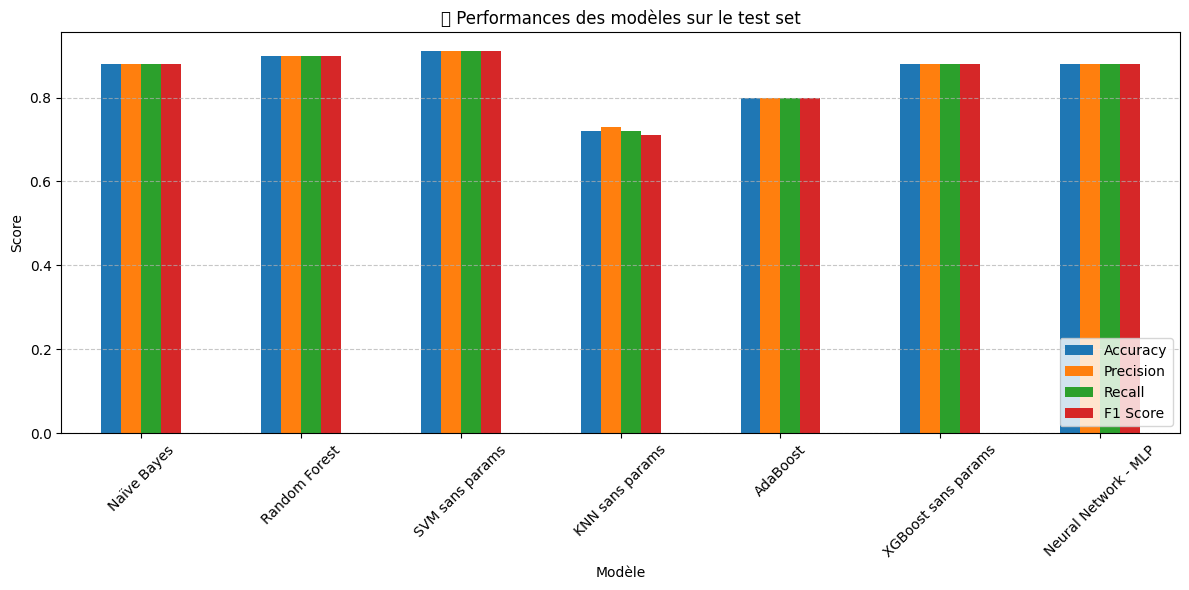

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold




# 6. Cross-validation stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 7. Modèles
scores = {}
models = {
    "Naïve Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "SVM sans params": SVC(kernel ='linear'),
    "KNN sans params": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost sans params": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Neural Network - MLP": MLPClassifier(max_iter=300),
}

# Scorers personnalisés
scorers = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score, average='weighted'),
    "Recall": make_scorer(recall_score, average='weighted'),
    "F1 Score": make_scorer(f1_score, average='weighted')
}

# 8. Entraînement + Évaluation + Cross-validation
for name, model in models.items():
    print(f"\n🔍 Entraînement du modèle : {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Cross-validation avec moyenne ± écart-type
    cv_results = {}
    for metric_name, scorer in scorers.items():
        cv_scores = cross_val_score(model, X_final, y, cv=cv, scoring=scorer)
        mean = cv_scores.mean()
        std = cv_scores.std()
        cv_results[metric_name] = f"{mean:.2f} ± {std:.2f}"

    scores[name] = {
        "Accuracy": f"{acc:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}",
        "F1 Score": f"{f1:.2f}",
        "CV Accuracy": cv_results["Accuracy"],
        "CV Precision": cv_results["Precision"],
        "CV Recall": cv_results["Recall"],
        "CV F1 Score": cv_results["F1 Score"]
    }

    print(f"\n📊 Scores Test : {name}")
    print(f"Accuracy : {acc:.2f} | Precision : {precision:.2f} | Recall : {recall:.2f} | F1 : {f1:.2f}")
    print("📄 Classification Report :")
    print(classification_report(y_test, y_pred))
    print("🧩 Matrice de confusion :")
    print(confusion_matrix(y_test, y_pred))

    # Matrice de confusion
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion - {name}')
    plt.xlabel('Prédiction')
    plt.ylabel('Vraie étiquette')
    plt.show()
    print("-" * 50)

# 9. Visualisation globale des scores
df_scores = pd.DataFrame(scores).T

# Affichage de la table complète (avec les ± pour le rapport)
display(df_scores)

# ⚠️ Pour tracer, on extrait juste les scores test simples (pas les ±)
plot_df = df_scores[["Accuracy", "Precision", "Recall", "F1 Score"]].astype(float)

plot_df.plot(kind='bar', figsize=(12, 6))
plt.title("📊 Performances des modèles sur le test set")
plt.xlabel("Modèle")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
#-----------------------------------------------------------------------
#----------Optuna-------------------------------------
#------------------------------------------------------------------

In [13]:
import optuna
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score

# --- Objectif pour Linear SVM avec validation croisée ---
def objective_svm(trial):
    C = trial.suggest_float("C", 1e-3, 10.0, log=True)
    model = SVC(kernel ='linear',C=C)

    # Validation croisée 5-fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_final2, y2, cv=cv, scoring=make_scorer(accuracy_score))

    return scores.mean()

# Créer et lancer l'étude
study_svm = optuna.create_study(direction="maximize")
study_svm.optimize(objective_svm, n_trials=500)

# Résultats
print("\n=== Résultats Optuna pour SVM linéaire ===")
print("Meilleurs paramètres:", study_svm.best_params)
print("Meilleure accuracy moyenne (cross-val) :", study_svm.best_value)


[I 2025-04-25 20:02:02,668] A new study created in memory with name: no-name-c0e1dd36-19ef-4e83-bb05-14ca2baafa5f
[I 2025-04-25 20:02:03,174] Trial 0 finished with value: 0.8450980392156863 and parameters: {'C': 6.250894143087888}. Best is trial 0 with value: 0.8450980392156863.
[I 2025-04-25 20:02:03,632] Trial 1 finished with value: 0.8444444444444444 and parameters: {'C': 4.605181131113254}. Best is trial 0 with value: 0.8450980392156863.
[I 2025-04-25 20:02:04,133] Trial 2 finished with value: 0.8457516339869281 and parameters: {'C': 1.171450881103059}. Best is trial 2 with value: 0.8457516339869281.
[I 2025-04-25 20:02:04,933] Trial 3 finished with value: 0.626797385620915 and parameters: {'C': 0.0011214929578554369}. Best is trial 2 with value: 0.8457516339869281.
[I 2025-04-25 20:02:05,470] Trial 4 finished with value: 0.8444444444444444 and parameters: {'C': 0.8619552667976943}. Best is trial 2 with value: 0.8457516339869281.
[I 2025-04-25 20:02:06,268] Trial 5 finished with va


=== Résultats Optuna pour SVM linéaire ===
Meilleurs paramètres: {'C': 0.6232407359036234}
Meilleure accuracy moyenne (cross-val) : 0.85359477124183


In [15]:
import optuna
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score

# --- Objectif pour Linear SVM avec validation croisée ---
def objective_svm(trial):
    C = trial.suggest_float("C", 1e-3, 10.0, log=True)
    model = AdaBoostClassifier()

    # Validation croisée 5-fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_final2, y2, cv=cv, scoring=make_scorer(accuracy_score))

    return scores.mean()

# Créer et lancer l'étude
study_svm = optuna.create_study(direction="maximize")
study_svm.optimize(objective_svm, n_trials=500)

# Résultats
print("\n=== Résultats Optuna pour AdaBoostClassifier sans params ===")
print("Meilleurs paramètres:", study_svm.best_params)
print("Meilleure accuracy moyenne (cross-val) :", study_svm.best_value)

[I 2025-04-25 20:34:59,105] A new study created in memory with name: no-name-638e1cea-9e85-48fc-8633-448a343f1c7f
[I 2025-04-25 20:34:59,716] Trial 0 finished with value: 0.765359477124183 and parameters: {'C': 5.122308627064975}. Best is trial 0 with value: 0.765359477124183.
[I 2025-04-25 20:35:00,262] Trial 1 finished with value: 0.765359477124183 and parameters: {'C': 0.4674676816349788}. Best is trial 0 with value: 0.765359477124183.
[I 2025-04-25 20:35:00,800] Trial 2 finished with value: 0.765359477124183 and parameters: {'C': 0.25401304729650964}. Best is trial 0 with value: 0.765359477124183.
[I 2025-04-25 20:35:01,339] Trial 3 finished with value: 0.765359477124183 and parameters: {'C': 0.004294907755744512}. Best is trial 0 with value: 0.765359477124183.
[I 2025-04-25 20:35:01,873] Trial 4 finished with value: 0.765359477124183 and parameters: {'C': 0.21020684399256204}. Best is trial 0 with value: 0.765359477124183.
[I 2025-04-25 20:35:02,408] Trial 5 finished with value: 0


=== Résultats Optuna pour AdaBoostClassifier sans params ===
Meilleurs paramètres: {'C': 5.122308627064975}
Meilleure accuracy moyenne (cross-val) : 0.765359477124183


In [16]:
#c'est le bon code lui

import optuna
from sklearn.neural_network import MLPClassifier


# --- Objectif pour Neural Network (MLP) ---
def objective_mlp(trial):
    hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", [(50,), (100,), (50, 50), (100, 50)])
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate_init, max_iter=500)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study_mlp = optuna.create_study(direction="maximize")
study_mlp.optimize(objective_mlp, n_trials=500)
print("\n=== Résultats Optuna pour Neural Network (MLP) ===")
print("Meilleurs paramètres:", study_mlp.best_params)
print("Meilleure accuracy obtenue:", study_mlp.best_value)

[I 2025-04-25 20:39:32,799] A new study created in memory with name: no-name-173f93dc-cdff-4fa6-9b02-619250520df4
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
/Users/salhinina/Desktop


=== Résultats Optuna pour Neural Network (MLP) ===
Meilleurs paramètres: {'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.00011401399147950403}
Meilleure accuracy obtenue: 0.9150326797385621
